<a href="https://colab.research.google.com/github/ajmauney/opencv_age_detection/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import dlib
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [ ]:
# Adapted from: https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  # get OpenCV format image
  img = js_to_image(data) 
  return img

<IPython.core.display.Javascript object>

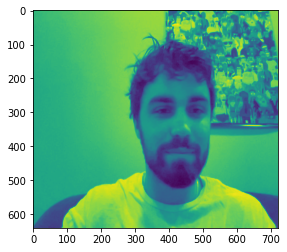

In [ ]:
img = take_photo()
#img = cv2.imread('girl1.jpg')
img = cv2.resize(img, (720, 640))
frame = img.copy()
hat = cv2.imread('Screen Shot 2022-05-09 at 2.31.58 PM.png')
beard = cv2.imread('beard.webp')  
cowboy_hat = cv2.imread('cowboyhat.jpeg')
old_hat = cv2.imread('oldhat\.jpeg')
beard_height, beard_width = beard.shape[0], beard.shape[1]
cowboy_height, cowboy_width = cowboy_hat.shape[0], cowboy_hat.shape[1]
old_hat_height, old_hat_width = old_hat.shape[0], old_hat.shape[1]



# ------------ Model for Age detection --------#
age_weights = "age_deploy.prototxt"
age_config = "age_net.caffemodel"
age_Net = cv2.dnn.readNet(age_config, age_weights)
  
# Model requirements for image
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
           '(25-32)', '(38-43)', '(48-53)', '(60-100)']
model_mean = (78.4263377603, 87.7689143744, 114.895847746)
  
# storing the image dimensions
fH = img.shape[0]
fW = img.shape[1]
  
Boxes = []  # to store the face co-ordinates
mssg = 'Face Detected'  # to display on image
  
# ------------- Model for face detection---------#
face_detector = dlib.get_frontal_face_detector()
# converting to grayscale
img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)


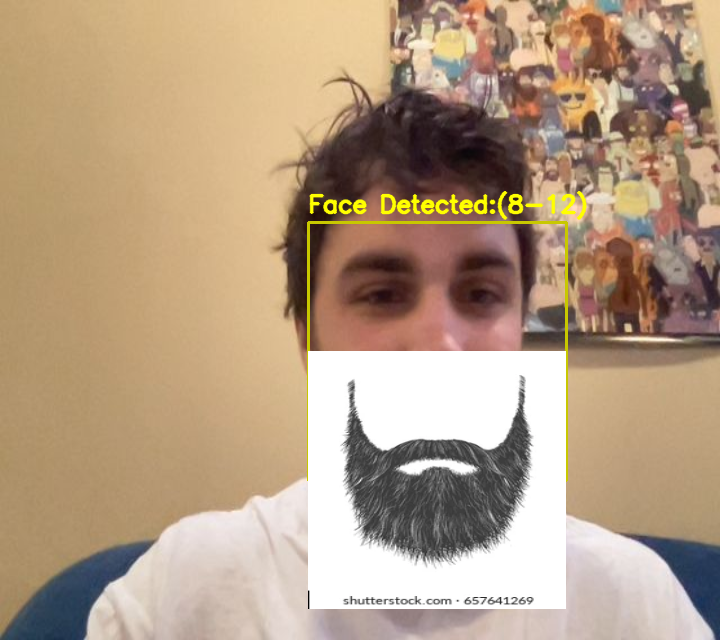

In [ ]:
faces = face_detector(img_gray)
  
# If no faces our detected
if not faces:
    mssg = 'No face detected'
    cv2.putText(img, f'{mssg}', (40, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (200), 2)
    cv2_imshow(img)
    cv2.waitKey(0)
  
else:
    # --------- Bounding Face ---------#
      for face in faces:
        x = face.left()  # extracting the face coordinates
        y = face.top()
        x2 = face.right()
        y2 = face.bottom()
  
        # rescaling those coordinates for our image
        box = [x, y, x2, y2]
        Boxes.append(box)
        cv2.rectangle(frame, (x, y), (x2, y2), 
                      (00, 200, 200), 2)

        for box in Boxes:
          face = frame[box[1]:box[3], box[0]:box[2]]
    
          # ----- Image preprocessing --------#
          blob = cv2.dnn.blobFromImage(
              face, 1.0, (227, 227), model_mean, swapRB=False)
    
          # -------Age Prediction---------#
          age_Net.setInput(blob)
          age_preds = age_Net.forward()
          age = ageList[age_preds[0].argmax()]
          if age == '(0-2)' or age == '(4-6)':
            hat = cv2.resize(hat, ((x2-x), (y2-y)))
            hat_height, hat_width = hat.shape[0], hat.shape[1]
            print(hat_height)
            if y-hat_height < 0:
              print('hat off screen trying to place: ', y-hat_height - (y-hat_height))
              frame[0:hat_height, x:x2] = hat
            else:
              frame[y-hat_height:y, x:x2] = hat
          if age == '(8-12)' or age == '(15-20)':
            beard = cv2.resize(beard, ((x2-x), (y2-y)))
            beard_height, beard_width = beard.shape[0], beard.shape[1]
            frame[(y2+y)//2:((y2+y)//2) + beard_height, x:x2] = beard
          if age == '(25-32)' or age == '(38-43)':
            cowboy_hat = cv2.resize(cowboy_hat, ((x2-x), (y2-y)))
            cowboy_height, cowboy_width = cowboy_hat.shape[0], cowboy_hat.shape[1]
            if y-cowboy_height < 0:
              print('hat off screen trying to place: ', y-cowboy_height - (y-cowboy_height))
              frame[0:cowboy_height, x:x2] = cowboy_hat
            else:
              frame[y-cowboy_height:y, x:x2] = cowboy_hat
          if age == '(48-53)' or age == '(60-100)':
            old_hat = cv2.resize(old_hat, ((x2-x), (y2-y)))
            old_hat_height, old_hat_width = old_hat.shape[0], old_hat.shape[1]
            if y-cowboy_height < 0:
              print('hat off screen trying to place: ', y-old_hat_height - (y-old_hat_height))
              frame[0:old_hat_height, x:x2] = old_hat
            else:
              frame[y-old_hat_height:y, x:x2] = old_hat

    
          cv2.putText(frame, f'{mssg}:{age}', (box[0],
                                              box[1] - 10), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                      (0, 255, 255), 2, cv2.LINE_AA)

          cv2_imshow(frame)
          cv2.waitKey(0)